In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt 

### ransan算法流程:

ransanc算法与最小二乘算法相比,最大的区别就是数据集有内点和外点的区别,ransanc算法只在内点数据上估计模型参数,而舍弃外点数据集对模型的影响.

### 1.伪代码如下:

In [2]:
def ransacMatching(A, B):
    #A,B是成对的匹配点
    maxiter#最大迭代次数
    iters = 1
    totalnums = len(A)#数据点个数
    mask = zeros()#标记数据点为内点or外点
    bestMask  #保存内点数目最多的内点序列
    maxInnerPointNum = 0
    th#判断是否内点的阈值
    while(iters <= maxiter):
        a,b = random4Pairs2dPoint(A,B)#随机抽取4个点对,作为内点
        models = get4PointsHomography(a,b)#估计模型参数
        innerPointsNum = 0
        for j in range(totalnums):
            if checkInnerPoint(A[j],B[j],models,th):
                mask[j] = 1
                innerPointsNum += 1
        if innerPointsNum > maxInnerPointNum:
            maxInnerPointNum = innerPointsNum
            bestMask = mask
        iters += 1
    innerA = A[bestMask]
    innerB = B[bestMask]
    models = getLSHomography(innerA,innerB)#用所有的内点(大于4个点)采用最小二乘的方式,重新估计模型参数
    return models       

### 2.真实代码如下

In [3]:
def calTriArea(x):#通过行列式计算面积
    epsilon = 10
    cal_x = np.hstack((x,np.ones((3,1))))
    det_x = abs(np.linalg.det(cal_x)/2)
    if det_x < epsilon:
        return False
    else:
        return True

In [4]:
#用于检查随机选取的四个点对是否满足非共线性要求(不能有三点共线)
def goCheckPoints(x):
    #通过三点围成面积是否为0判断三点是否共线
    all_idxs = np.arange(x.shape[0])
    if calTriArea(x[all_idxs!=0,:]) and calTriArea(x[all_idxs!=1,:]) and calTriArea(x[all_idxs!=2,:]) and calTriArea(x[all_idxs!=3,:]):
        return True
    else:
        return False                                                                            

In [5]:
#用于从数据点集中随机选择出四对点
def getRandom4Pairs2dPoint(A,B):
    all_idxs = np.arange(A.shape[0])  # 获取下标索引
    while True:
        np.random.shuffle(all_idxs)  # 打乱下标索引
        a = A[all_idxs[0:4],:]
        b = B[all_idxs[0:4],:]
        if goCheckPoints(a):
            return all_idxs[0:4],all_idxs[4:]

In [6]:
def calSqareErrors(a,b,model):
    a = np.hstack((a,np.ones((a.shape[0],1))))
    tempHomo = np.dot(a,model)
    x = tempHomo[:,2].reshape(tempHomo.shape[0],1)
    temp = tempHomo/x
    error = np.sum((b-temp[:,0:2])**2,axis=1)
    return error

In [5]:
#用于从数据点集中随机选择出四对点
def getRandom4Pairs2dPoint(A,B):
    all_idxs = np.arange(A.shape[0])  # 获取下标索引
    while True:
        np.random.shuffle(all_idxs)  # 打乱下标索引
        a = A[all_idxs[0:4],:]
        b = B[all_idxs[0:4],:]
        if goCheckPoints(a):
            return all_idxs[0:4],all_idxs[4:]

### 关于最大迭代次数k的推导

**1. 确定最大迭代次数的基本思路:**

假设样本点对一共有m对,确定模型参数最少需要n个点对,则可以得到,在样本点对中遍历所有可能的n点组合,必定能够找到最优的模型参数,即最大的迭代次数$k=C^{n}_{m}$.

实际上,我们并不需要遍历所有的m点对组合,因为样本点对中实际的内点数目远不止n对,假设为r对,则在只要在依次随机抽取中抽到了n个实际的内点,则我们已经找到了最优的模型参数.所以,实际上,样本集中内点所占比例越大,一次随机收取到n个内点的概率越大,我们所需要的最大迭代次数就越少.

**2. 数学推导过程**

假设样本集一共有m个点对,确定模型参数最少需要n个点对,样本集中内点的比例为$\omega$,则一次随机抽取n个点对全部为内点的概率为$\omega^{n}$,则一次随机抽取n个点对不全部为内点的概率为$1-\omega^{n}$,则连续K次随机抽取均不全部为内点的概率为$(1-\omega^{n})^{k}$,假设我们模型的置信度p,则可得$1-p=(1-\omega^{n})^{k}$.两边同取log可得:$$ k = \frac{log(1-p)}{log(1-\omega^{n})}$$
此处置信度p是人为设置的,内点比例$\omega$可以在模型中通过估计得到,因此通过上式就可以确定出最大迭代次数.具体实现代码请参考updateMaxIters函数.

需要注意的一点是,上面公式估计的最大迭代次数是针对随机抽取有放回的形式,即在随机抽取时没有进行重复抽取检验,如果是非放回方式抽取,则上述公式需要进行修正,可以加上k的标准差,定义如下:$$SD(k)=\frac{\sqrt{1-\omega^{n}}}{\omega^{n}}$$
至于为何$\omega$的标准差定义为上式,没有进行深入研究,本程序中ransanc算法采用有放回的方式随机抽取样本点对.

In [7]:
#更新最大迭代次数
def updateMaxIters(p,m,r):#p置信度,m样本集总数,r本次迭代样本估计样本内点数目
    num = math.log(1-p)
    w = r/m
    deno = math.log(1-w**4)
    maxIters = round(num/deno)
    return maxIters

In [8]:
#计算单应性矩阵,主要通过特征分解的方式
def getLsHomography(a,b):
    alen = a.shape[0]
    A = np.zeros((9,9))
    for i in range(alen):
        l1 = np.array([a[i,0],a[i,1],1,0,0,0,-a[i,0]*b[i,0],-a[i,1]*b[i,0],-b[i,0]])
        l2 = np.array([0,0,0,a[i,0],a[i,1],1,-a[i,0]*b[i,1],-a[i,1]*b[i,1],-b[i,1]])
        l1 = l1.reshape(1,9)
        l2 = l2.reshape(1,9)
        A = A + np.dot(l1.T,l1)+np.dot(l2.T,l2)
    retval,_,e_vecs = cv2.eigen(A)
    if retval:
        H = e_vecs[-1,:]
        H = H.reshape(3,3)
        H = H/H[2,2]
    return H

In [9]:
def ransanc(A,B,maxiters=2000,p=0.99,th=3):#A,B为成对的匹配点(A.i与B.i匹配),maxiters最大迭代次数,p模型置信度,th判断是否内点的阈值
    plen = A.shape[0]#总的数据点数目
    iters = 1
    bestMask = np.zeros(plen)#内点数目最多时,对应的掩模
    maxInnerPointNums = 0 #最大的内点数目
    while iters <= maxiters:
        inner_idx,test_idx = getRandom4Pairs2dPoint(A,B)#随机抽取4个点对,作为内点
        model = getLsHomography(A[inner_idx,:],B[inner_idx,:])#由4个点对估计模型参数
#         model,_ = cv2.findHomography(A[inner_idx,:],B[inner_idx,:])
        testerror = calSqareErrors(A[test_idx,:],B[test_idx,:],model.T)
        also_idx = test_idx[testerror<th]
        innerPointsNum = 4+len(also_idx)
        if innerPointsNum > maxInnerPointNums:
            maxInnerPointNums = innerPointsNum
            bestMask[inner_idx] = 1
            bestMask[also_idx] = 1
        maxiters = updateMaxIters(p,plen,innerPointsNum)
        iters+=1 
    innerA = A[bestMask>0,:]
    innerB = B[bestMask>0,:]
#     plt.scatter(A[bestMask>0,0],A[bestMask>0,1],c ='r')
#     plt.scatter(A[bestMask==0,0],A[bestMask==0,1],c ='g')
    finalmodel = getLsHomography(innerA,innerB)
#     finalmodel,_ = cv2.findHomography(innerA,innerB)
    return finalmodel.T,bestMask

#### 2.1通过随机生成的数据点对,验证自己编写的ransanc性能

通过比较发现,在随机生成点对时,**若不添加噪声**,则两种方法均能较好还原单应性矩阵.**当添加噪声后**,两个函数求得的单应性矩阵均出现了偏差,对比矩阵的数值,总体而言,cv2库函数具有较高的鲁棒性猜测是因为库函数采用了一些数值处理技巧,增加了矩阵求解抗噪声性能.

In [10]:
#用于生成2d点对,作为数据集使用.内部包含模型内点和模型外点,生成算法参考了助教老师的方法
def gen2dPointPairs(totalPointNum,outPointNum,ifAddNoise):
    #1.生成理想的数据点对
    pl = 20*np.random.random((2,totalPointNum,))#x,y都在0-20的范围内随机选择
    #齐次坐标
    pl = np.vstack((pl,np.ones((1,totalPointNum))))
    #随机生成一个单应性H矩阵
    H = np.random.rand(3,3)
    H_norm2 = np.linalg.norm(H)
    H = H/H[2,2]
    #生成对应的2d Points
    pr = np.dot(H,pl)
    pr = pr/pr[2,:]
    #添加高斯噪声
    if ifAddNoise:
        pl_noise = pl + np.random.randn(3,totalPointNum)*0.01
        pr_noise = pr + np.random.randn(3,totalPointNum)*0.01
    else:
        pl_noise = pl
        pr_noise = pr
    #2.生成模型之外的点对
    all_idxs = np.arange(pl_noise.shape[1])
    np.random.shuffle(all_idxs)  # 将all_idxs打乱
    outlier_idxs = all_idxs[:outPointNum]
    pl_noise[:,outlier_idxs] = 30 * np.random.random((3, outPointNum))
    pr_noise[:,outlier_idxs] = 50 * np.random.random((3, outPointNum))
#     plt.scatter(pl_noise[0,:],pl_noise[1,:],c='r')
#     plt.scatter(pl_noise[0,outlier_idxs],pl_noise[1,outlier_idxs],c='g')
    plt.show()
    A = pl_noise[0:2,:]
    B = pr_noise[0:2,:]
    return A.T,B.T,H.T

In [11]:
#比较自己写的求解单应性矩阵函数和cv库自带函数的区别
totalPointNum = 90
outPointNum = 10
A,B,H = gen2dPointPairs(10,0,0)
H0,_ = cv2.findHomography(A,B,cv2.RANSAC)
H1,_ = cv2.findHomography(A,B)
H2 = getLsHomography(A,B)
print('H0:',H0)
print('H1:',H1)
print('H2:',H2)

H0: [[2.22929315 2.70833298 3.13899189]
 [0.4747274  1.48782277 3.46205254]
 [1.98100866 3.21225402 1.        ]]
H1: [[2.22929315 2.70833298 3.13899189]
 [0.4747274  1.48782277 3.46205254]
 [1.98100866 3.21225402 1.        ]]
H2: [[2.22931065 2.70835397 3.13900888]
 [0.47473125 1.48783433 3.46207507]
 [1.9810243  3.21227889 1.        ]]


In [12]:
#利用随机的二位点对,比较自己编写的ransac算法和cv2库函数cv2.findHomography
def test_randomdataset():
    totalPointNum = 30
    outPointNum = 3
    A,B,H = gen2dPointPairs(totalPointNum,outPointNum,1)
    model,_ = ransanc(A,B,maxiters=2000,p=0.99,th=0.001)
    print('H:',H)
    print('model:',model)
    model_x,_ = cv2.findHomography(A,B,cv2.RANSAC,4.0) 
    print('model_x:',model_x)

In [13]:
test_randomdataset()

H: [[0.34829945 3.12347832 0.04454467]
 [3.74684686 1.79918986 0.20853522]
 [1.4166195  0.4916738  1.        ]]
model: [[-0.75301326 -0.79914333 -0.05896745]
 [-0.30818369 -0.5332626  -0.03023272]
 [11.56097787 14.59944775  1.        ]]
model_x: [[0.35431466 3.76664367 1.35837891]
 [3.14140037 1.80684192 0.47193588]
 [0.04512459 0.20966565 1.        ]]


#### 2.2利用两幅不同视角下的图像验证ransanc算法

两幅图像利用sift算法提取特征点,然后匹配特征点,并通过ransac算法计算两幅图像之间的单应性矩阵,利用计算得到的单应性矩阵变换原始图像,观察图像变换结果.

In [15]:
# perspective transform
def random_warp(img, row, col):
    height, width = img.shape

    # warp:
    random_margin = 60

    dx1 = np.random.randint(0, random_margin)
    dy1 = np.random.randint(0, random_margin)
    dx2 = np.random.randint(width - random_margin - 1, width - 1)
    dy2 = np.random.randint(0, random_margin)
    dx3 = np.random.randint(width - random_margin - 1, width - 1)
    dy3 = np.random.randint(height - random_margin - 1, height - 1)
    dx4 = np.random.randint(0, random_margin)
    dy4 = np.random.randint(height - random_margin - 1, height - 1)

    pts1 = np.float32([[0, 0], [width-1,0], [width-1,height-1], [0,height-1]])
    pts2 = np.float32([[dx1, dy1], [dx2, dy2], [dx3, dy3], [dx4, dy4]])
    M_warp = cv2.getPerspectiveTransform(pts1, pts2)
    
    img_warp = cv2.warpPerspective(img, M_warp, (width, height))
    return M_warp, img_warp

In [25]:
def getMatchPoints(img1,img2):
    #初始化sift算子
    sift = cv2.xfeatures2d.SIFT_create()
    # 提取特征点和坐标位置
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # 寻找对应的匹配点
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
    good_2 = np.expand_dims(good, 1)
    #绘出特征点之间的连线
    matching = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_2,None, flags=2)
    plt.imshow(matching),plt.show()
    if len(good)>4:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,2)
        #利用ransac算法估计单应性矩阵和内点标记掩模
        model,mask = ransanc(src_pts,dst_pts,maxiters=2000,p=0.99,th=0.5)
        #model_v, mask_v = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        #利用估计的单应性矩阵变换原始图像
        wrap = cv2.warpPerspective(img1, model.T, (img1.shape[1]+img2.shape[1] , max(img1.shape[0],img2.shape[0])))
        #组合透视变换图像和利用ransanc估计的单应性矩阵变换后的图像,便于对比显示
        wrap[:, img1.shape[1]:] = img2
        #绘出经过ransanc算法筛选后的内点连线
        matchfinal = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_2[mask>0,],None, flags=2)
        plt.imshow(matchfinal),plt.show()
        rows, cols = np.where(wrap!=0)
        min_row, max_row = min(rows), max(rows) +1
        min_col, max_col = min(cols), max(cols) +1
        result = wrap[min_row:max_row,min_col:max_col]#去除黑色无用部分
    return result

        

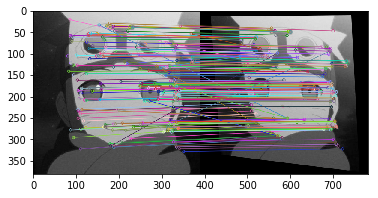

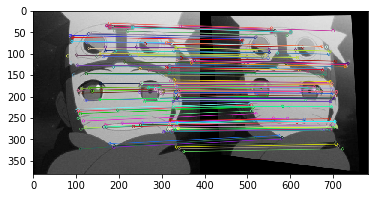

In [26]:
img = cv2.imread('naruto.png',0)
#对原始图像进行透视变换
M_warp, img_warp = random_warp(img, img.shape[0], img.shape[1])
#通过sift和ransanc得到透视变换后的图像(左图)和估计的单应性矩阵变换后的图像(右图)
ima_new = getMatchPoints(img,img_warp)
cv2.imshow("ima_new", ima_new)
key = cv2.waitKey(0)
if key == 27:
    cv2.destroyAllWindows()

#### 2.3结论

- 通过对比透视变换图像和通过ransac估计的单应性矩阵变换得到的图像组合,可以发现两幅图像基本一致,反映出ransac算法估计的单应性矩阵与我们在投影变换时使用的单应性矩阵是基本一致的.

- 通过对比ransac算法筛选前后特征点对的连线可以发现,经过ransac算法筛选,交叉的斜线少了,也即错误的特征匹配点对被过滤了.